In [146]:
from collections import defaultdict
from dataclasses import dataclass
import os
import sys
import yaml
import time
import numpy as np
import scipy.io
import scipy.linalg
import scipy.sparse as sp
import matplotlib.pyplot as plt
from src.common import NDArrayFloat
from src.linalg import get_numpy_eigenvalues
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import RectBivariateSpline



In [147]:
import numpy as np
import scipy.sparse as sp

def generate_matrix(type: str, sparse: bool, size: int, min_val: float, max_val: float, grouping_factor: float = 0, density: float = 1) -> np.array:
  """Generates various types of REAL matrices with controlled value range and diagonal grouping.

  Args:
    type: The type of matrix to generate.
          Options: 'nonsymmetric', 'symmetric', 'normal', 'orthogonal'.
    sparse: Whether to generate a sparse matrix.
    size: The size of the matrix (size x size).
    min_val: Minimum value of the matrix elements.
    max_val: Maximum value of the matrix elements.
    grouping_factor: Controls the strength of diagonal grouping. 
                     0: No grouping.
                     Positive values: Increase grouping strength.

  Returns:
    A NumPy array representing the generated matrix.
  """
  if type == 'nonsymmetric':
    if sparse:
      A = sp.rand(size, size, density=density, format='csr').toarray()
    else:
      A = np.random.rand(size, size)
    if grouping_factor > 0:
      for i in range(size):
        A[i, :] = A[i, :] * (1 + grouping_factor * i / (size-1)) # Scale based on distance and factor
    return A * (max_val - min_val) + min_val

  elif type == 'symmetric':
    if sparse:
      A = sp.rand(size, size, density=density, format='csr')
      A = (A + A.transpose()).toarray() / 2
    else:
      A = np.random.rand(size, size)
      A = (A + A.T) / 2
    if grouping_factor > 0:
      for i in range(size):
        for j in range(size):
          A[i, j] = A[i, j] * np.exp(-grouping_factor * abs(i - j) / (size - 1)) # Exponential decay from diagonal
    return A * (max_val - min_val) + min_val

  elif type == 'normal':
    if sparse:
      raise ValueError("Sparse normal matrices are not well-defined.")
    else:
      # Generate a symmetric matrix (guaranteed to be normal)
      A = np.random.rand(size, size)
      A = (A + A.T) / 2
      if grouping_factor > 0:
        for i in range(size):
          for j in range(size):
            A[i, j] = A[i, j] * np.exp(-grouping_factor * abs(i - j) / (size - 1)) # Exponential decay from diagonal
      return A * (max_val - min_val) + min_val

  elif type == 'orthogonal':
    if sparse:
      raise ValueError("Sparse orthogonal matrices are not well-defined.")
    else:
      Q, _ = np.linalg.qr(np.random.rand(size, size))
      if grouping_factor > 0:
        for i in range(size):
          Q[i, :] = Q[i, :] * (1 + grouping_factor * i / (size-1)) # Scale based on distance and factor
      return Q * (max_val - min_val) + min_val

  else:
    raise ValueError(f"Invalid matrix type: {type}")

In [148]:
def plot_matrix_3d(matrix: np.array, title: str = "Matrix 3D Plot"):
  """Plots a matrix as a 3D surface plot.

  Args:
    matrix: The NumPy array representing the matrix.
    title: The title for the plot (optional).
  """

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Create the grid for x and y coordinates
  rows, cols = matrix.shape
  x = np.arange(cols)
  y = np.arange(rows)
  X, Y = np.meshgrid(x, y)

  # Plot the surface
  surf = ax.plot_surface(X, Y, matrix, cmap=cm.viridis)

  # Add labels and title
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Value")
  ax.set_title(title)

  # Add a colorbar
  fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

  plt.show()


In [149]:
def plot_2d_temperature(matrix, title="Temperature Plot of Matrix"):
  """
  Plots a 2D temperature map of a matrix, highlighting the largest elements.

  Args:
    matrix: The input numpy array (matrix).
    title: The title of the plot.
  """

  fig, ax = plt.subplots()

  # Plot the temperature map
  im = ax.imshow(matrix, cmap='hot', interpolation='nearest')

  # Add a colorbar
  cbar = fig.colorbar(im, ax=ax)
  cbar.set_label('Value')

  # Add labels and title
  ax.set_xlabel('Column Index')
  ax.set_ylabel('Row Index')
  ax.set_title(title)

  plt.show()

In [150]:
def testing(my_function, A: np.array, name: str,show_plots: bool=False):
  """Compares your eigenvalue algorithm with NumPy's eigvals.

  Args:
    my_function: Your function that takes a NumPy array (matrix)
                  and returns a NumPy array of eigenvalues.
    A: The input matrix for eigenvalue calculation.
  """

  # Calculate eigenvalues using your function and NumPy
  start_time = time.time()
  my_eigenvalues = my_function(A)
  my_time = time.time() - start_time

  start_time = time.time()
  numpy_eigenvalues = np.linalg.eigvals(A)
  numpy_time = time.time() - start_time

  # Sort eigenvalues for consistent comparison
  my_eigenvalues.sort()
  numpy_eigenvalues.sort()

  # Accuracy
  errors = np.abs(my_eigenvalues - numpy_eigenvalues)
  max_error = np.max(errors)
  avg_error = np.mean(errors)

  print("----- Eigenvalue Comparison -----")
  print(f'{name}:')
  print("  Time:", my_time, "seconds")
  print("NumPy eigvals:")
  print("  Time:", numpy_time, "seconds")
  print("\nAccuracy:")
  print("  Maximum Error:", max_error)
  print("  Average Error:", avg_error)
  if(show_plots):
    # Plot the differences
    plt.figure(figsize=(8, 6))
    plt.plot(my_eigenvalues, label=name)
    plt.plot(numpy_eigenvalues, label="NumPy eigvals")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.title("Eigenvalue Comparison")
    plt.legend()
    plt.show()

    # Plot the errors
    plt.figure(figsize=(8, 6))
    plt.plot(errors)
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Absolute Error")
    plt.title("Eigenvalue Errors")
    plt.show()


In [151]:
def test_all(matrix_dict: dict, my_function,show_plots: bool=False):
    for matrix_id,items in matrix_dict.items():
        name = items[1]
        matrix = items[0]
        testing(my_function=my_function,A=matrix,name=name,show_plots=show_plots)
        if(show_plots):
            plot_2d_temperature(matrix=matrix,title=name)

In [152]:
nonsymmetric_matrix_sparse = generate_matrix('nonsymmetric', True, 500, 100, 1000,density=0.2)
nonsymmetric_matrix_bottom_group = generate_matrix('nonsymmetric', False, 500, 100, 1000,grouping_factor=1000)
symmetric_matrix = generate_matrix('symmetric', False, 500, 0, 10)
symmetric_matrix_diag = generate_matrix('symmetric', False, 500, 0, 10,grouping_factor=5)
orthogonal_matrix = generate_matrix('orthogonal', False, 500, 0, 1)
symmetric_matrix_diag_sparse = generate_matrix('symmetric', True, 1000, 0, 1000,grouping_factor=3,density=0.3)

matrix_dict = {
    1 : [nonsymmetric_matrix_sparse, "nonsymmetric_matrix_sparse"],
    2 : [nonsymmetric_matrix_bottom_group, "nonsymmetric_matrix_bottom_group"],
    3 : [symmetric_matrix,"symmetric_matrix"],
    4 : [symmetric_matrix_diag, "symmetric_matrix_diag"],
    5 : [orthogonal_matrix, "orthogonal_matrix"],
    6 : [symmetric_matrix_diag_sparse, "symmetric_matrix_diag_sparse"]
}

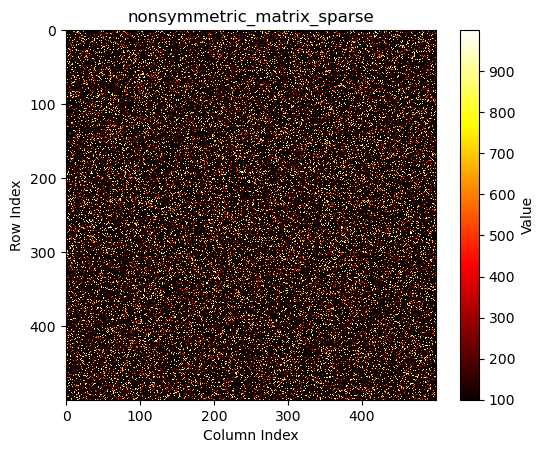

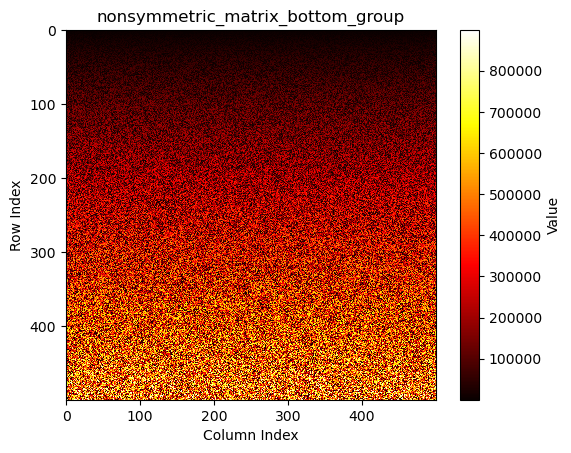

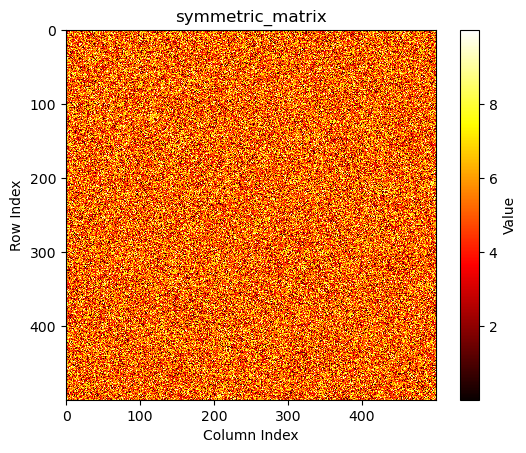

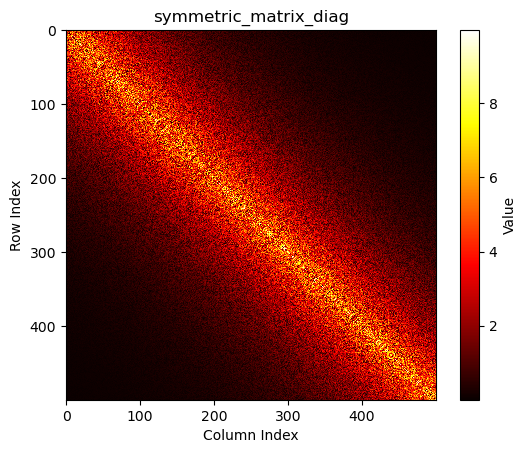

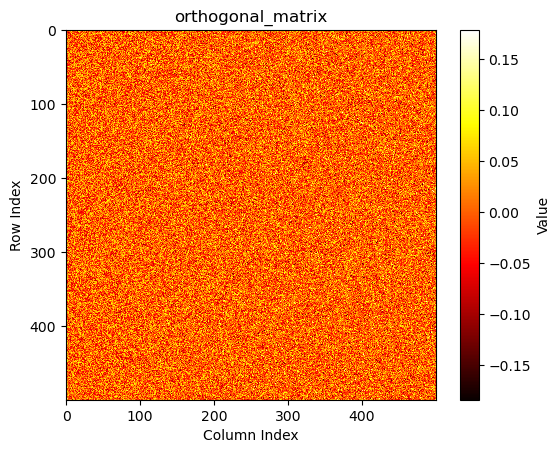

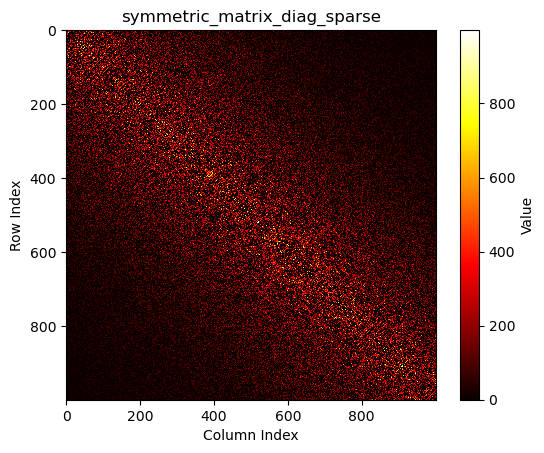

In [153]:
for matrix_id,items in matrix_dict.items():
    name = items[1]
    matrix = items[0]
    plot_2d_temperature(matrix=matrix,title=name)

In [154]:
def qr(A: NDArrayFloat) -> NDArrayFloat:
    n = A.shape[0]
    Q = np.zeros_like(A)
    R = np.zeros_like(A)
    W = A.copy()
    
    for j in range(n):
        w_j_norm = np.linalg.norm(W[: , j])
        Q[: , j ] = W[: , j] / w_j_norm # W[: , j] == w_j^j
        for i in range(j):
            R[i,j] = A[: , j] @ Q[:, i]
        a_j_norm = np.linalg.norm(A[:, j])
        R[j,j] = np.sqrt(a_j_norm**2 - np.sum(R[ :j , j] ** 2))
        for k in range(j+1,n):
            prod = W[: , k] @ Q[: , j]
            W[:, k ] = W[: , k] - prod * Q[:, j]
    return Q,R

def get_all_eigenvalues(A: NDArrayFloat) -> NDArrayFloat:
    A_k = A.copy()
    n_iters = 10
    for k in range(n_iters):
        Q, R = qr(A_k)
        A_k = R @ Q
    out = np.array(np.diag(A_k), dtype=np.float64)
    return out

In [155]:
testing(get_all_eigenvalues, symmetric_matrix, "basic QR algorithm")

----- Eigenvalue Comparison -----
basic QR algorithm:
  Time: 6.061913728713989 seconds
NumPy eigvals:
  Time: 0.07481908798217773 seconds

Accuracy:
  Maximum Error: 66.85270873449917
  Average Error: 33.21439438784936


----- Eigenvalue Comparison -----
nonsymmetric_matrix_sparse:
  Time: 6.1737847328186035 seconds
NumPy eigvals:
  Time: 0.09748315811157227 seconds

Accuracy:
  Maximum Error: 4710.516709133503
  Average Error: 2939.250071664482


/opt/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


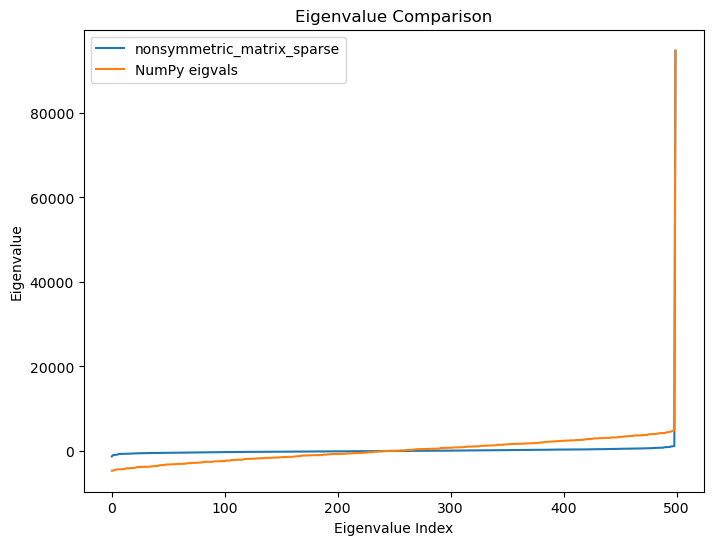

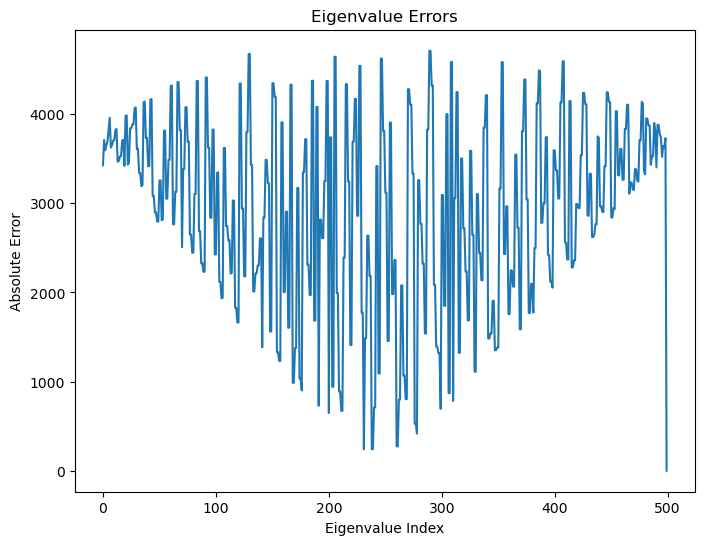

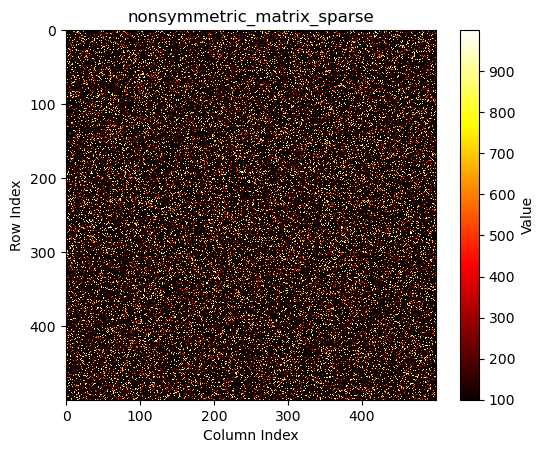

----- Eigenvalue Comparison -----
nonsymmetric_matrix_bottom_group:
  Time: 6.045614957809448 seconds
NumPy eigvals:
  Time: 0.10920882225036621 seconds

Accuracy:
  Maximum Error: 3467718.251557459
  Average Error: 1598008.5861687597


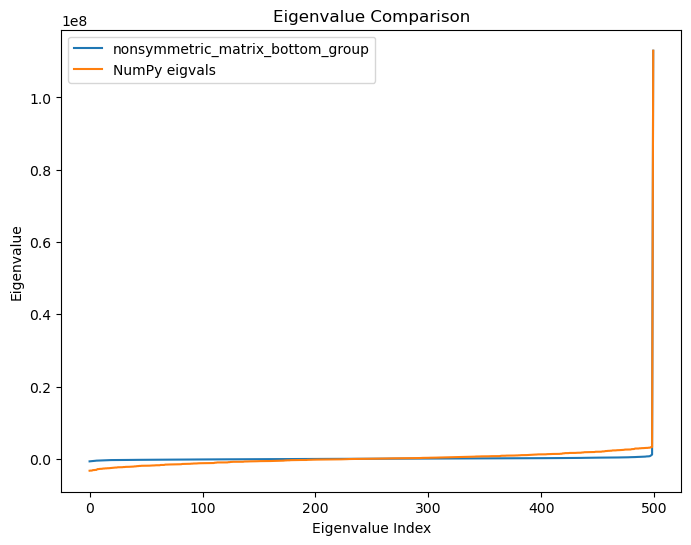

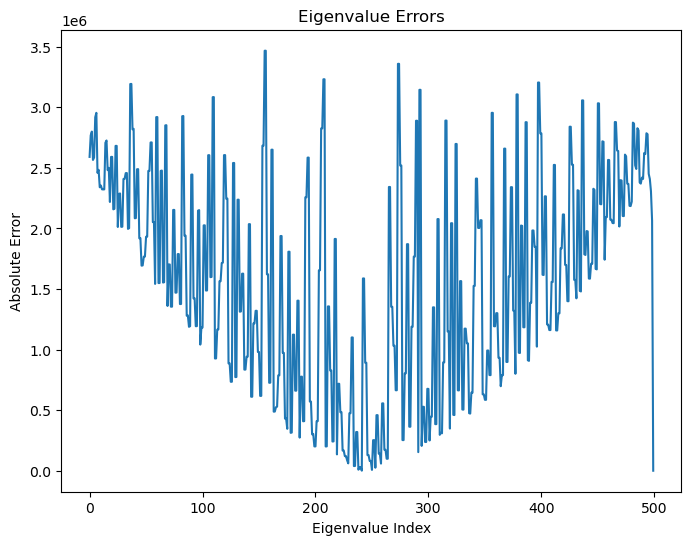

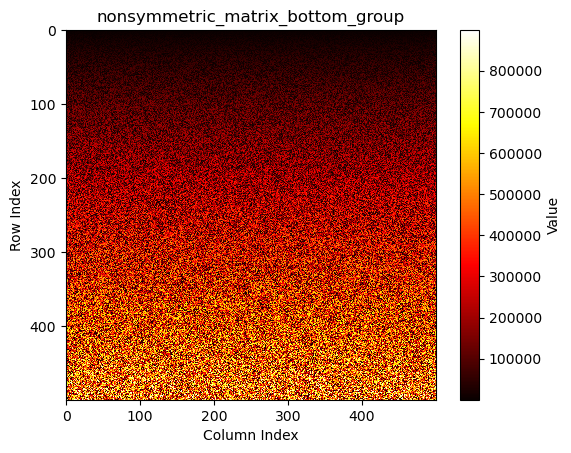

----- Eigenvalue Comparison -----
symmetric_matrix:
  Time: 6.096088171005249 seconds
NumPy eigvals:
  Time: 0.09505891799926758 seconds

Accuracy:
  Maximum Error: 66.85270873449917
  Average Error: 33.21439438784936


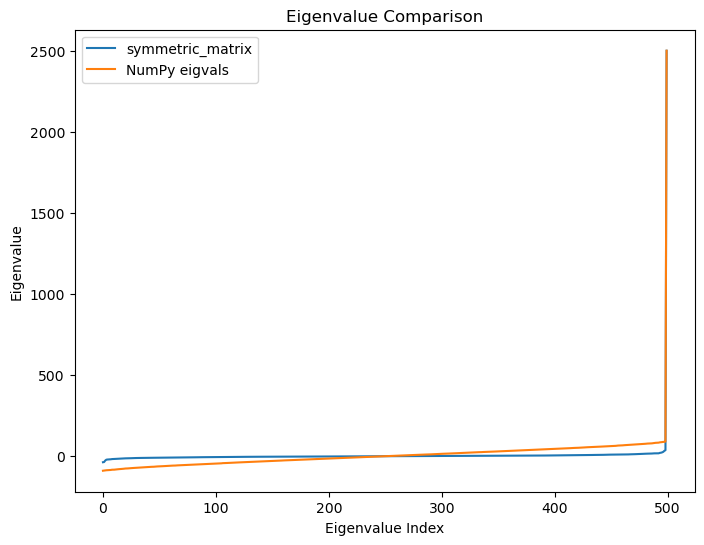

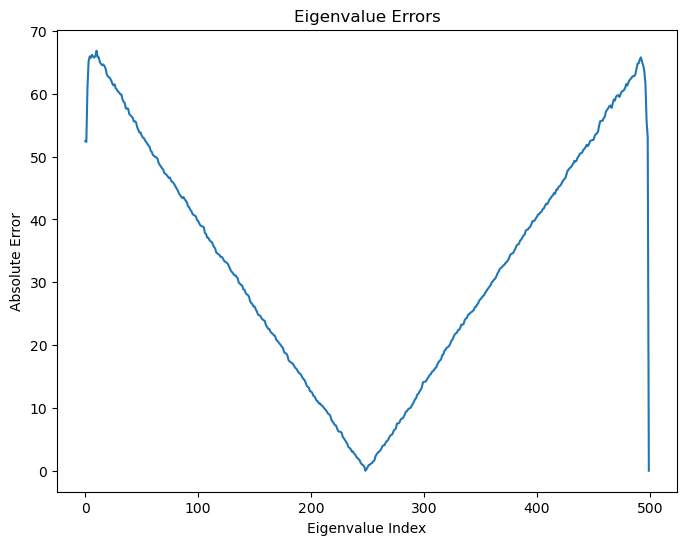

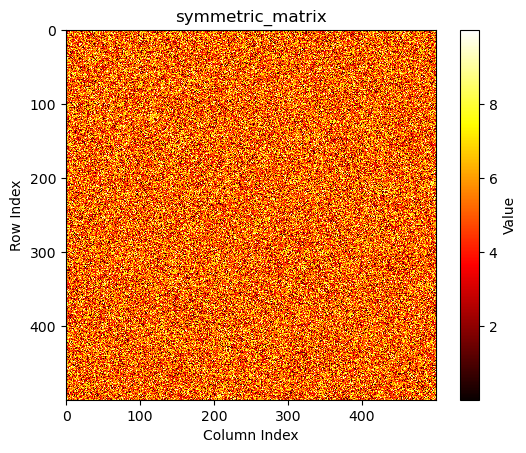

----- Eigenvalue Comparison -----
symmetric_matrix_diag:
  Time: 5.872858047485352 seconds
NumPy eigvals:
  Time: 0.15085196495056152 seconds

Accuracy:
  Maximum Error: 28.549172941304825
  Average Error: 13.658827176670988


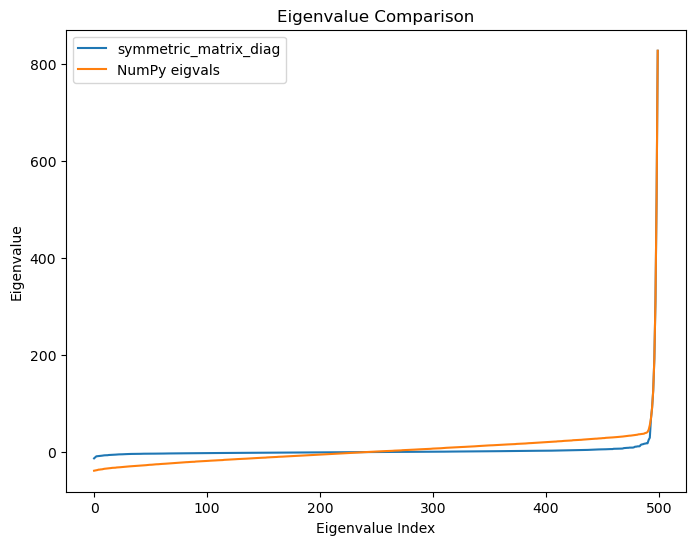

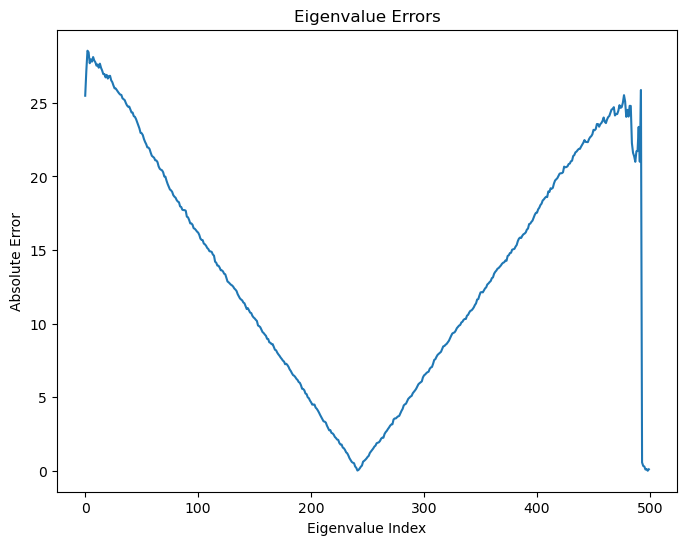

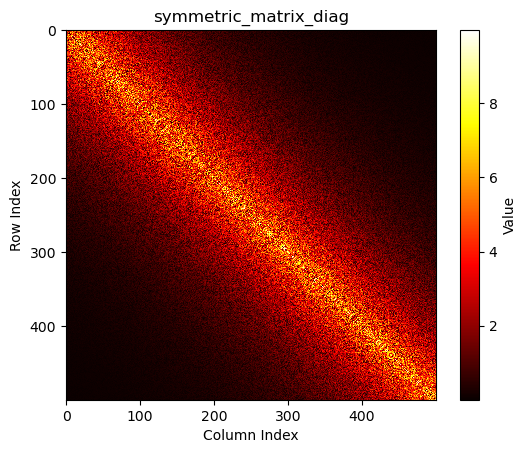

----- Eigenvalue Comparison -----
orthogonal_matrix:
  Time: 6.175415992736816 seconds
NumPy eigvals:
  Time: 0.10396194458007812 seconds

Accuracy:
  Maximum Error: 1.0043407813507996
  Average Error: 0.9751838347240918


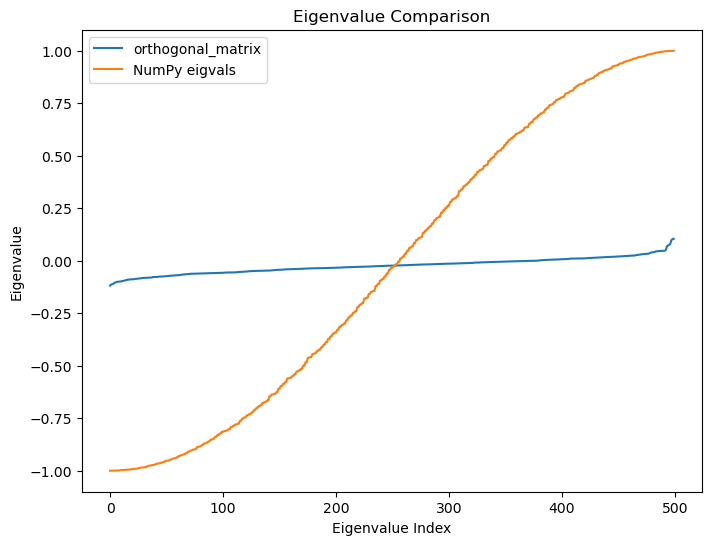

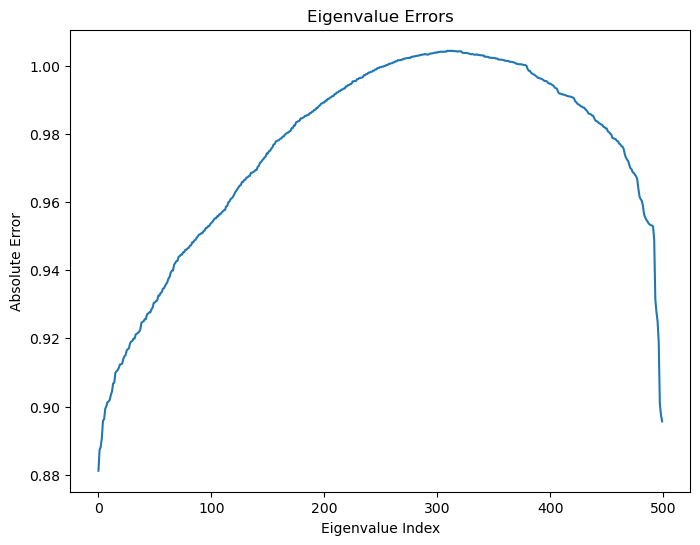

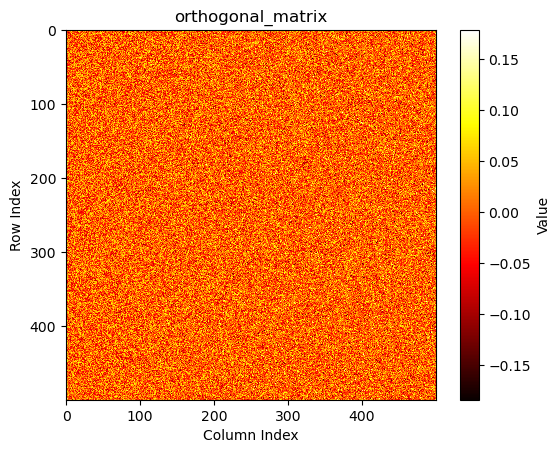

----- Eigenvalue Comparison -----
symmetric_matrix_diag_sparse:
  Time: 33.60227704048157 seconds
NumPy eigvals:
  Time: 0.36179304122924805 seconds

Accuracy:
  Maximum Error: 5273.448125460176
  Average Error: 2487.5256417025003


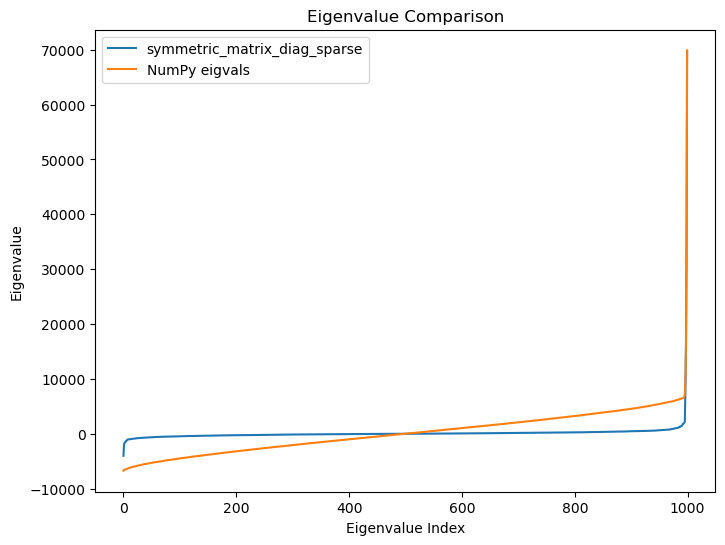

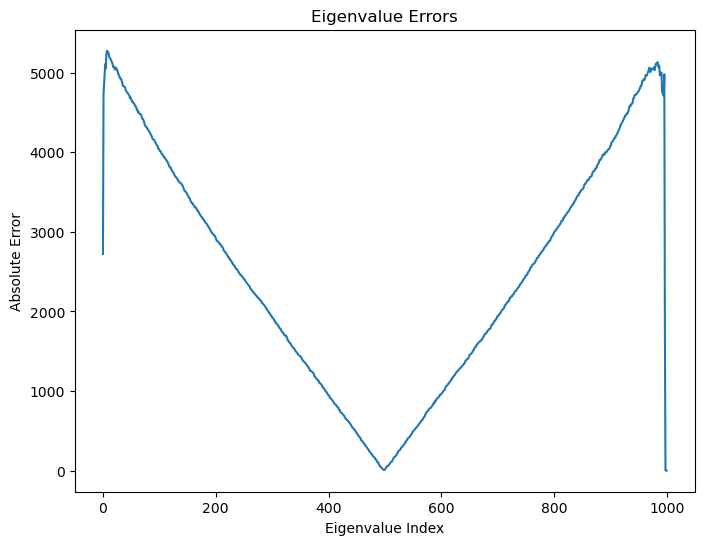

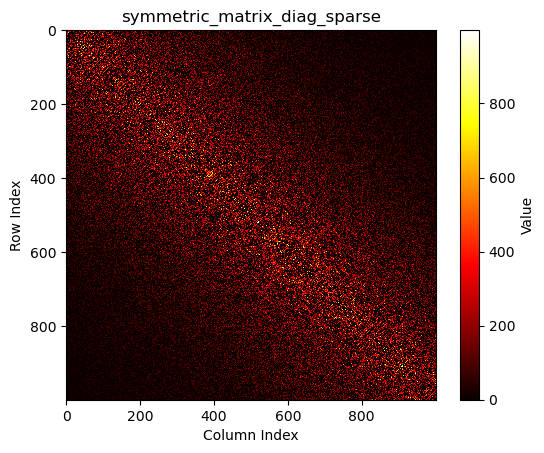

In [156]:
test_all(matrix_dict=matrix_dict,my_function=get_all_eigenvalues,show_plots=True)